# Figures for NRL Seminar Talk
All of the figures for my NRL seminar talk

In [1]:
import os
import sys

import numpy as np
import scipy.stats
from scipy.ndimage import gaussian_filter
from scipy.interpolate import splev,splrep,splprep,interp1d
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
from astropy.visualization import ImageNormalize,AsinhStretch,SqrtStretch
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.modeling
from sunpy.map import Map,GenericMap
import sunpy.coordinates
import sunpy

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA

sys.path.append('/storage-home/w/wtb2/projects/synthesized_timelag_maps/scripts/')
from timelags import AIATimeLags
from idl_colormaps import bgry_004_idl_cmap

%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/matplotlib/__init__.py:576: UserWarning: matplotlibrc text.usetex can not be used with *Agg backend unless dvipng-1.6 or later is installed on your system
  'your system' % dvipng_req)


## AR Building

## Loop Hydrodynamics

In [2]:
ar_high = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/field_checkpoint/')
ar_intermediate = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/field_checkpoint/')
ar_low = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/field_checkpoint/')

In [3]:
i_loop = 6#np.random.randint(0,len(ar_base.loops),size=1)[0]

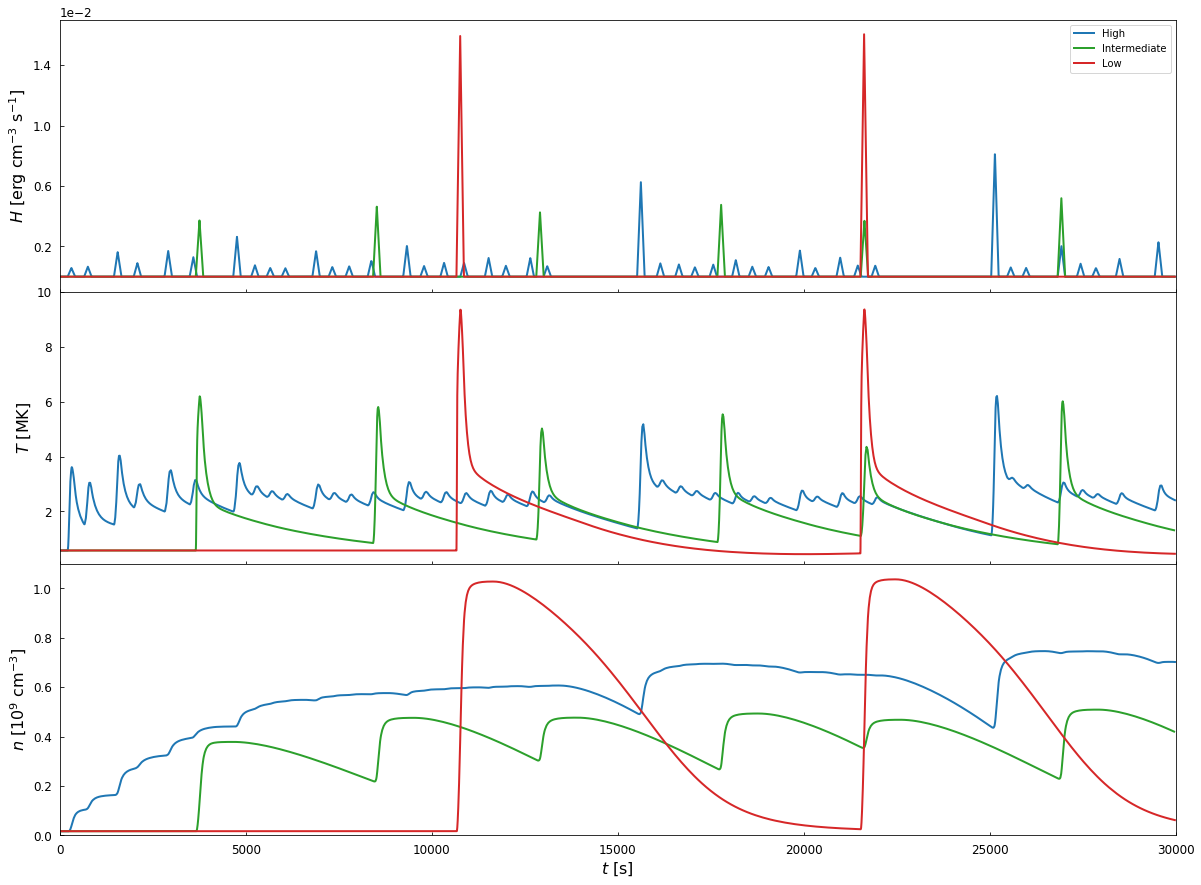

In [55]:
fig,axes = plt.subplots(3,1,figsize=(20,15),sharex=True)
# Heating
## Read the heating 
h = np.loadtxt(os.path.join(os.path.dirname(
    ar_high.loops[i_loop].parameters_savefile),f'hydro_results/{ar_high.loops[i_loop].name}'))[:,-1]
axes[0].plot(ar_high.loops[i_loop].time, h, color='C0',label='High')
h = np.loadtxt(os.path.join(os.path.dirname(
    ar_intermediate.loops[i_loop].parameters_savefile),f'hydro_results/{ar_intermediate.loops[i_loop].name}'))[:,-1]
axes[0].plot(ar_intermediate.loops[i_loop].time, h, color='C2',label='Intermediate')
h = np.loadtxt(os.path.join(os.path.dirname(
    ar_low.loops[i_loop].parameters_savefile),f'hydro_results/{ar_low.loops[i_loop].name}'))[:,-1]
axes[0].plot(ar_low.loops[i_loop].time, h, color='C3',label='Low')
axes[0].tick_params(axis='both',which='both',direction='in')
axes[0].legend()

# Temperature
axes[1].plot(ar_high.loops[i_loop].time,ar_high.loops[i_loop].electron_temperature[:,0].to(u.MK),color='C0',)
axes[1].plot(ar_intermediate.loops[i_loop].time,ar_intermediate.loops[i_loop].electron_temperature[:,0].to(u.MK),color='C2',)
axes[1].plot(ar_low.loops[i_loop].time,ar_low.loops[i_loop].electron_temperature[:,0].to(u.MK),color='C3',)
axes[1].tick_params(axis='both',which='both',direction='in')

# Density
axes[2].plot(ar_high.loops[i_loop].time,ar_high.loops[i_loop].density[:,0]/1e9,color='C0',)
axes[2].plot(ar_intermediate.loops[i_loop].time,ar_intermediate.loops[i_loop].density[:,0]/1e9,color='C2',)
axes[2].plot(ar_low.loops[i_loop].time,ar_low.loops[i_loop].density[:,0]/1e9,color='C3',)
axes[2].tick_params(axis='both',which='both',direction='in')

# Labels and limits
axes[0].set_xlim(0,3e4)
axes[0].set_ylim(-1e-3,1.7e-2)
axes[0].set_yticks(axes[0].get_yticks()[2:-1:2])
axes[0].ticklabel_format(style='sci',axis='y',scilimits=(0,1))
axes[1].set_ylim(0.1,10)
axes[2].set_ylim(0,1.1)
axes[0].set_ylabel(r'$H$ [erg cm$^{-3}$ s$^{-1}$]')
axes[1].set_ylabel(r'$T$ [MK]')
axes[2].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[2].set_xlabel(r'$t$ [s]')

# Adjustments
plt.subplots_adjust(hspace=0.)
fig.savefig('img/hydro_profiles.png',dpi=300,format='png',transparent=True,bbox_inches='tight')

## Intensity Maps

In [39]:
path_format = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{}/nei/SDO_AIA/{}/map_t{:06d}.fits'

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


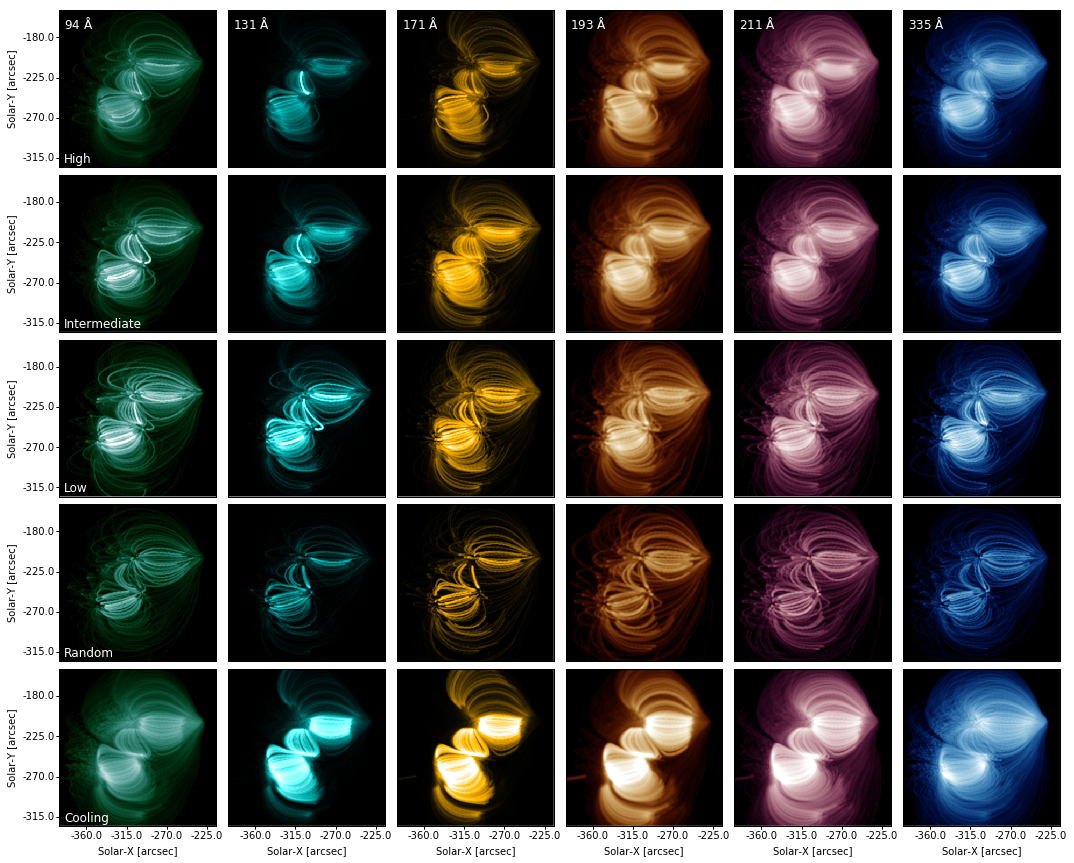

In [54]:
fig = plt.figure(figsize=(18,15))
vmax = {'94':5e1,'131':2e2,'171':2.5e3,'193': 2e3, '211': 1e3, '335':1e2}
labels = {'high_frequency': 'High Frequency','intermediate_frequency':'Intermediate Frequency','low_frequency':'Low Frequency',
          'cooling_outofphase_long':'Random', 'cooling':'Cooling'}
for i,f in enumerate(['high_frequency','intermediate_frequency','low_frequency', 'cooling_outofphase_long', 'cooling']):
    for j,c in enumerate(['94','131','171','193','211','335']):
        t = 1500 if f != 'cooling' else 150
        m = Map(path_format.format(f,c,t))
        m = m.submap(SkyCoord(Tx=-390*u.arcsec,Ty=-325*u.arcsec,frame=m.coordinate_frame),
                     SkyCoord(Tx=-215*u.arcsec,Ty=-150*u.arcsec,frame=m.coordinate_frame))
        ax = fig.add_subplot(5,6,6*i+j+1,projection=m)
        norm = ImageNormalize(vmin=0,vmax=vmax[c],stretch=AsinhStretch(0.01))
        m.plot(axes=ax,title=False,annotate=False,norm=norm)
        ax.grid(alpha=0)
        lon,lat = ax.coords[0],ax.coords[1]
        if i < 4:
            lon.set_ticklabel_visible(False)
            lon.set_ticks_visible(False)
        else:
            #lon.set_ticks(values=([-400,-300,-200]*u.arcsec).to(u.deg))
            lon.set_axislabel('Solar-X [arcsec]')
        if j > 0:
            lat.set_ticklabel_visible(False)
            lat.set_ticks_visible(False)
        else:
            #lat.set_ticks(values=([-350,-250,-150]*u.arcsec).to(u.deg))
            lat.set_axislabel('Solar-Y [arcsec]',)#minpad=2)
        if i == 0:
            xtext,ytext = m.world_to_pixel(SkyCoord(-385*u.arcsec, -170*u.arcsec, frame=m.coordinate_frame))
            ax.text(xtext.value,ytext.value,f'{c} $\mathrm{{\AA}}$',color='w',fontsize=plt.rcParams['xtick.labelsize'])
        if j == 0:
            xtext,ytext = m.world_to_pixel(SkyCoord(-385*u.arcsec, -320*u.arcsec, frame=m.coordinate_frame))
            ax.text(xtext.value,ytext.value,f'{labels[f].split()[0]}',color='w',fontsize=plt.rcParams['xtick.labelsize'])
plt.subplots_adjust(wspace=0.05,hspace=0.05)
fig.savefig('img/aia_maps.png',dpi=300,format='png',transparent=True,bbox_inches='tight')

## Timelags

## Comparisons with Observations